In [12]:
# previous emulator selection is based on normKGE but rmse should be used
# this notebook shows using kge or rmse obtains quite different results

In [3]:
import sys, os, glob, pickle, toml, json, pickle, random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing

sys.path.append('../../MOASMO_support')
from mo_evaluation import get_modified_KGE

In [2]:
inpath_moasmo = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange'
outpath_all = f'{inpath_moasmo}/LargeSampleEmulator_exps_out'

outfile = f'{outpath_all}/SSE_GPR_normKGE_CV_estimates.pkl'

if os.path.isfile(outfile):
    with open(outfile, 'rb') as file:
        gpr_cv_results = pickle.load(file)

In [6]:
%%time

# evaluate GPR CV
def evaluate_cv(cv_results):
    # evaluation
    rmse_test = np.nan * np.zeros(len(cv_results))
    rmse_train = np.nan * np.zeros(len(cv_results))
    cc_test = np.nan * np.zeros(len(cv_results))
    cc_train = np.nan * np.zeros(len(cv_results))
    kge_test = np.nan * np.zeros(len(cv_results))
    kge_train = np.nan * np.zeros(len(cv_results))
    
    for fold in range(1, len(cv_results)+1):
        y_train, y_test, y_train_pred, y_test_pred = cv_results[fold]['y_train'], cv_results[fold]['y_test'], cv_results[fold]['y_train_pred'], cv_results[fold]['y_test_pred']
        
        # Evaluate the model using 
        rmse_test[fold - 1] = get_rmse(y_test, y_test_pred)
        rmse_train[fold - 1] = get_rmse(y_train, y_train_pred)
        cc_test[fold - 1] = get_cc(y_test, y_test_pred)
        cc_train[fold - 1] = get_cc(y_train, y_train_pred)
        
        kge_test[fold - 1] = get_modified_KGE(y_test, y_test_pred)
        kge_train[fold - 1] = get_modified_KGE(y_train, y_train_pred)
            
    return rmse_test, rmse_train, cc_test, cc_train, kge_train, kge_test


def get_rmse(d1, d2):
    return ( np.nanmean( (d1-d2)**2 ) ) ** 0.5

def get_cc(d1, d2):
    ind = ~np.isnan(d1+d2)
    return np.corrcoef(d1[ind], d2[ind])[0,1]


outfile = f'{outpath_all}/SSE_GPR_normKGE_CV_evaluation.npz'

numbasin = 627

if True:
    gpr_rmse_train = np.nan * np.zeros([numbasin, 5])
    gpr_rmse_test = np.nan * np.zeros([numbasin, 5])
    gpr_cc_train = np.nan * np.zeros([numbasin, 5])
    gpr_cc_test = np.nan * np.zeros([numbasin, 5])    
    gpr_kge_train = np.nan * np.zeros([numbasin, 5])
    gpr_kge_test = np.nan * np.zeros([numbasin, 5])    
    for i in range(len(gpr_cv_results)):
        gpr_rmse_test[i, :], gpr_rmse_train[i, :], gpr_cc_test[i, :], gpr_cc_train[i, :], gpr_kge_test[i, :], gpr_kge_train[i, :] = evaluate_cv(gpr_cv_results[i])


CPU times: user 1.57 s, sys: 10.3 ms, total: 1.58 s
Wall time: 3.3 s


In [7]:
outfile = f'{outpath_all}/SSE_RF_normKGE_CV_estimates.pkl'

if os.path.isfile(outfile):
    with open(outfile, 'rb') as file:
        rf_cv_results = pickle.load(file)

if True:
    rf_rmse_train = np.nan * np.zeros([numbasin, 5])
    rf_rmse_test = np.nan * np.zeros([numbasin, 5])
    rf_cc_train = np.nan * np.zeros([numbasin, 5])
    rf_cc_test = np.nan * np.zeros([numbasin, 5])    

    rf_kge_train = np.nan * np.zeros([numbasin, 5])
    rf_kge_test = np.nan * np.zeros([numbasin, 5])    
    for i in range(len(rf_cv_results)):
        rf_rmse_test[i, :], rf_rmse_train[i, :], rf_cc_test[i, :], rf_cc_train[i, :], rf_kge_test[i, :], rf_kge_train[i, :] = evaluate_cv(rf_cv_results[i])

In [8]:
gpr_rmse_m = np.nanmean(gpr_rmse_test, axis=1)
rf_rmse_m = np.nanmean(rf_rmse_test, axis=1)

gpr_kge_m = np.nanmean(gpr_kge_test, axis=1)
rf_kge_m = np.nanmean(rf_kge_test, axis=1)

print(np.sum(gpr_rmse_m<rf_rmse_m))
print(np.sum(gpr_kge_m>rf_kge_m))

330
483


(array([ 66., 147., 141.,  99.,  55.,  41.,  32.,  23.,  15.,   8.]),
 array([0.01040867, 0.02973694, 0.0490652 , 0.06839347, 0.08772173,
        0.10704999, 0.12637826, 0.14570652, 0.16503479, 0.18436305,
        0.20369131]),
 <BarContainer object of 10 artists>)

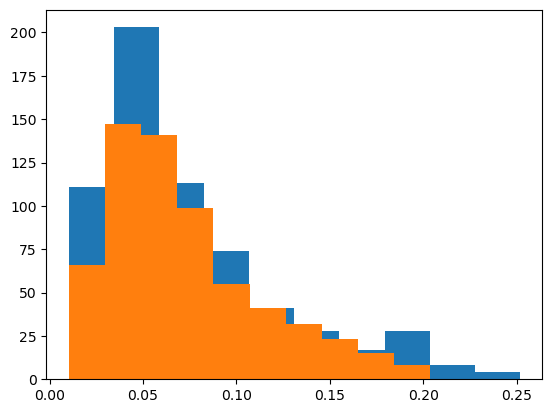

In [11]:
plt.hist(gpr_rmse_m)
plt.hist(rf_rmse_m)